**SVM** = support vector machine

# Linear SVM classification

**Linearly separable** classes : can be easily defined/separated with a straight line/plane in parameter space

**Large margin classification**: fitting widest possible "street" (i.e. gap parallel to decision boundary, the ) between classes to define decision boundary.

 > a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin)

**Support vectors**: instances in data that fully define ("support") the decision boundary - all other instances are not used

NB SVMs are **scale-dependent**: the widest possible margin boundary depends on the relative scale of each parameter, e.g. if one parameters scale >> others, the margin will be vertical in that axis

**Hard margin classification**: all instances must be off the street (not in the margin), and on the correct side of the decision boundary. Is sensitive to outliers, and only works when linearly separable.

**Soft margin classification**: allow for instances to be "in" the street (in the margin), or on the wrong side of the decision boundary = **margin violations**


In sklearn, `C` parameter controls how many margin violations are acceptable: smaller `C` = more violations.

NB `LinearSVC` can be much faster than `SVC(kernel='linear')`

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10, 8)

In [2]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [4]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # only use peta length, width
y = (iris['target'] == 2).astype(np.float64) # whether Iris virginica or not

In [24]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge'))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [25]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

**NB** unlike logistic regression, SVMs don't output class probabilities, only class predictions.

In [ ]:
# Instead of LienarSVC can also do:
SVC(kernel='linear', C=1)
# or
SGDClassifier(loss='hinge', alpha=1/(m*C))
# SGD doesn't converge as fast as SVM but can do out-of-core training or online classification

**NB** LinearSVC also regularises bias term - need to **center** training data by subtracting mean (already done in StandardScaler).

In [276]:
def draw_decision_boundary(pipeline, x_min, x_max, *plot_args, **plot_kwargs):
    # in the 2D plane, the boundary is a straight line
    # at the decision boundary, theta*x + b = 0
    # so y = -(theta1/theta2)x - (b/theta2)
    # but this is all complicated by scaling, which we have to "undo"
    # to get back into unscaled space
    scaler = pipeline.steps[0][1]
    mean1, mean2 = scaler.mean_
    sigma1, sigma2 = scaler.scale_
    
    # scaled variables passed to svm are
    # x' = (x - mean) / (scale)
    svm = pipeline.steps[1][1]
    theta = svm.coef_[0]
    theta1, theta2 = theta
    intercept = svm.intercept_[0]

    x = np.linspace(x_min, x_max, 50)
    
    m = -(theta1 * sigma2) / (theta2 * sigma1)
    c = mean2 + (sigma2 * theta1 * mean1) / (sigma1 * theta2) - (intercept * sigma2 / theta2)
    
    y = m*x +c

    plt.plot(x, y, *plot_args, **plot_kwargs)

In [29]:
svm_clf.steps

[('scaler', StandardScaler()), ('linear_svc', LinearSVC(C=1, loss='hinge'))]

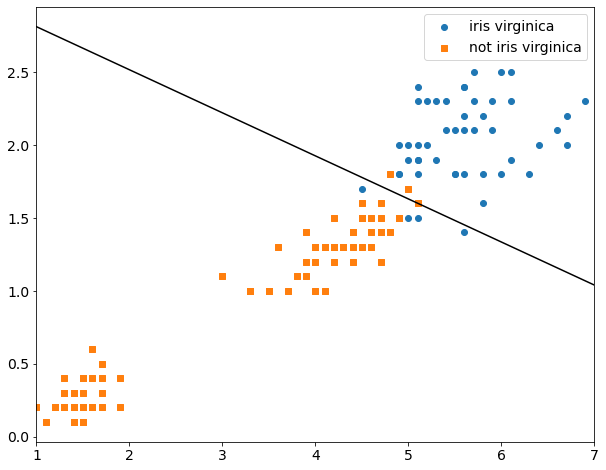

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(X[y==1, 0], X[y==1, 1], label='iris virginica')
ax.scatter(X[y==0, 0], X[y==0, 1], marker='s', label='not iris virginica')
svm = svm_clf.named_steps['linear_svc']
# draw decision boundary
x_min, x_max = 1, 7
draw_decision_boundary(svm_clf, x_min, x_max)
# highlight support vectors isn't possible for LinearSVC, unlike normal SVC?!
plt.xlim(x_min, x_max)
plt.legend();

# Nonlinear SVM classification

Most datasets aren't linearly separable - better to add more features, e.g. polynomial ones. Can turn datasets into linearly separable ones

Test on "moons" dataset - 2 interleaving half circles

In [3]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [102]:
X, y = make_moons(n_samples=100, noise=0.15)

In [117]:
polynomial_svm_clf = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])

In [118]:
X.shape

(100, 2)

In [119]:
y.shape

(100,)

In [120]:
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

In [131]:
def draw_moon_classification(clf, title):
    # draw decision areas by using contours
    x1 = np.linspace(-1.5, 2.5, 100)
    x2 = np.linspace(-1, 1.25, 100)
    X1, X2 = np.meshgrid(x1, x2)
    y_predict = clf.predict(np.c_[X1.reshape(-1, 1), X2.reshape(-1, 1)])
    y_predict = y_predict.reshape(X1.shape)
    
    plt.contourf(X1, X2, y_predict, cmap='Pastel2')
    plt.scatter(X[y==0, 0], X[y==0, 1], c='b', marker='s', label='y=0')
    plt.scatter(X[y==1, 0], X[y==1, 1], c='r', marker='o', label='y=1')
    plt.legend();
    plt.xlabel('$x_1$');
    plt.ylabel('$x_2$');
    plt.suptitle(title)

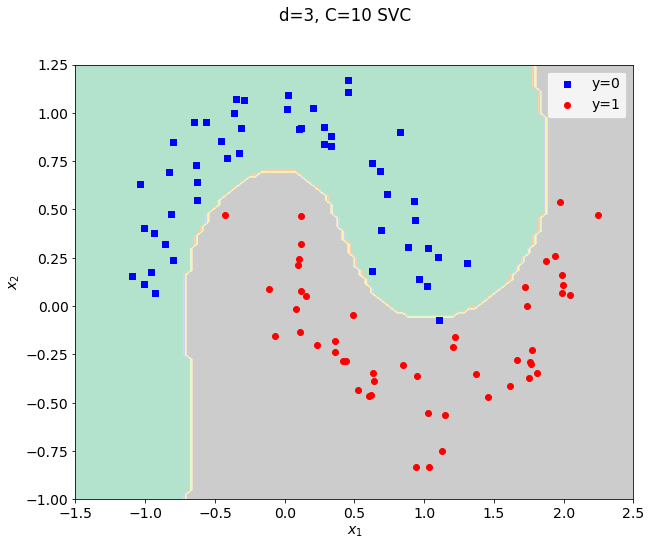

In [132]:
draw_moon_classification(polynomial_svm_clf, "d=3, C=10 SVC")

So degree 3 features make it _almost_ linearly separable (depending on exactly what random moon data you get). Trying higher order polynomials doesn't seem to improve the boundary, whilst a degree 2 polynomial underfits.

For comparison, here's a linear SVC:

In [109]:
linear_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', LinearSVC(C=10, loss='hinge'))
])
linear_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

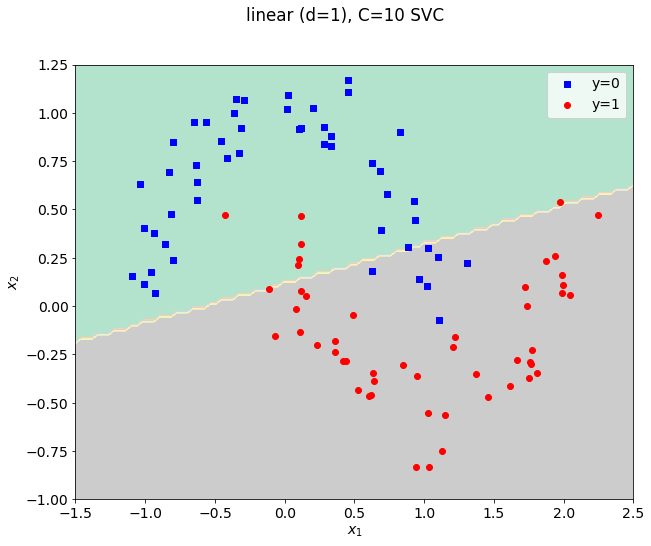

In [133]:
draw_moon_classification(linear_svm_clf, "linear (d=1), C=10 SVC");

Since it's linear, it clearly has a hard time.

## Polynomial Kernel

Downside to the above:

- cannot handle very complex datasets
- large degree = huge number of features - too slow

Instead can use **kernel trick** - as if you added polynomial features, but don't have to actually add them TODO: clarify what this means

Avoids # of features explosion.

`coef0` param: (known as $r$ in equations) how much to weight higher-order terms vs lower-orders

In [4]:
from sklearn.svm import SVC

In [137]:
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

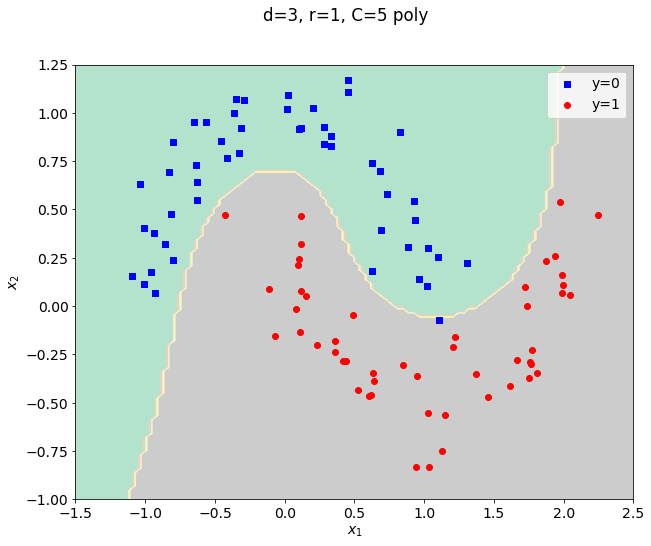

In [138]:
draw_moon_classification(poly_kernel_svm_clf, 'd=3, r=1, C=5 poly')

This looks similar to our earlier attempt when manually adding polynomial features.

We can also try a ridiculous degree to see it overfitting, reducing the regularisation strength to show it more clearly:

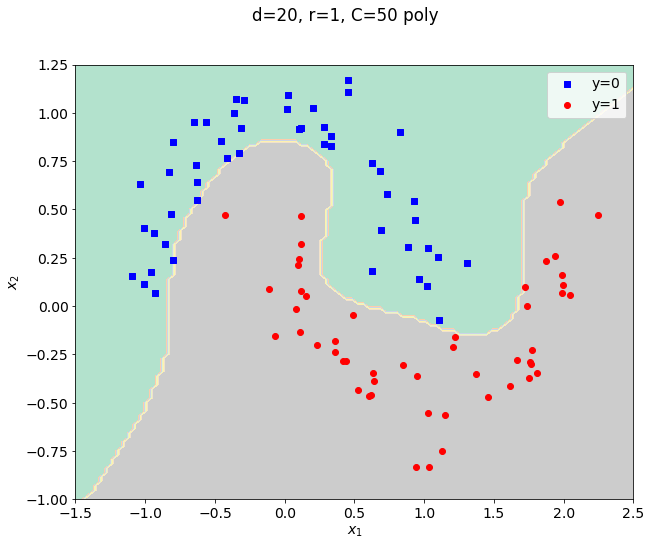

In [163]:
poly_kernel_svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='poly', degree=20, coef0=1, C=50))
])
poly_kernel_svm_clf.fit(X, y)

draw_moon_classification(poly_kernel_svm_clf, 'd=20, r=1, C=50 poly')

## Similarity Features

Add features using a **similarity function** - how close each data point is to a particular **landmark**.

Define a Gaussian similarity function - **radial basis function (RBF)**:

\begin{equation}
\phi(\vec{x}, \ell) = \exp \left( -\gamma \| \vec{x}-\ell \|^2 \right)
\end{equation}

**Increasing** $\gamma$ makes the distribution **narrower**, so each instance has a **smaller zone of influence**, making the decision boundary more irregular.

The distances to the landmarks can then be used in feature space, and certain combinations may become linearly separable.

Most comprehensive way is to add each dataset point as a landmark - but then you end up with $m \times m$ training data - can be huge.

## Gaussian RBF kernel

Can do **kernel trick** - use RBF kernel, without any need to explicitly create such a large dataset:

In [168]:
rbf_kernel_svm_clf_small_g_small_c = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=0.001))
])
rbf_kernel_svm_clf_small_g_small_c.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=0.1))])

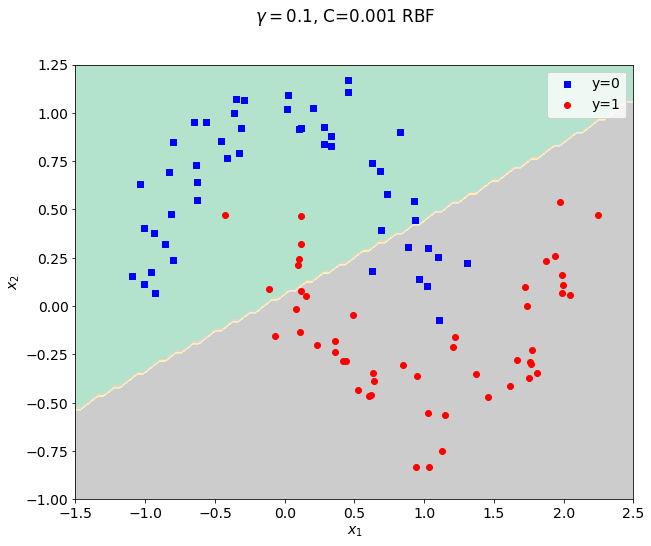

In [175]:
draw_moon_classification(rbf_kernel_svm_clf_small_g_small_c, '$\gamma=0.1$, C=0.001 RBF')

Small gamma and C basically turns it into a linear SVC.

In [167]:
rbf_kernel_svm_clf_small_g_large_c = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=0.1, C=1000))
])
rbf_kernel_svm_clf_small_g_large_c.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1000, gamma=0.1))])

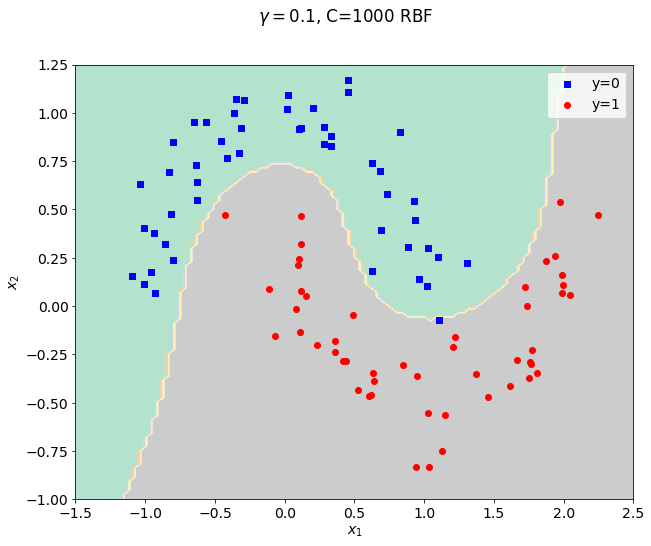

In [176]:
draw_moon_classification(rbf_kernel_svm_clf_small_g_large_c, '$\gamma=0.1$, C=1000 RBF')

In [171]:
rbf_kernel_svm_clf_large_g_small_c = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf_large_g_small_c.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

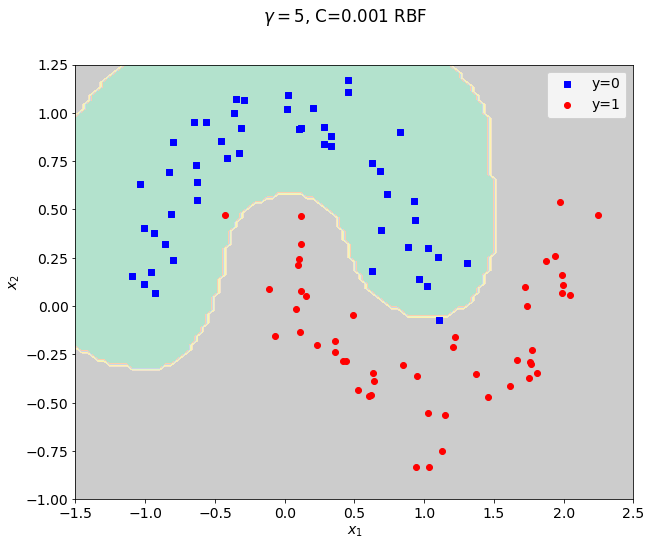

In [177]:
draw_moon_classification(rbf_kernel_svm_clf_large_g_small_c, '$\gamma=5$, C=0.001 RBF')

In [169]:
rbf_kernel_svm_clf_large_g_large_c = Pipeline([
    ('scaler', StandardScaler()),
    ('svm_clf', SVC(kernel='rbf', gamma=5, C=1000))
])
rbf_kernel_svm_clf_large_g_large_c.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1000, gamma=5))])

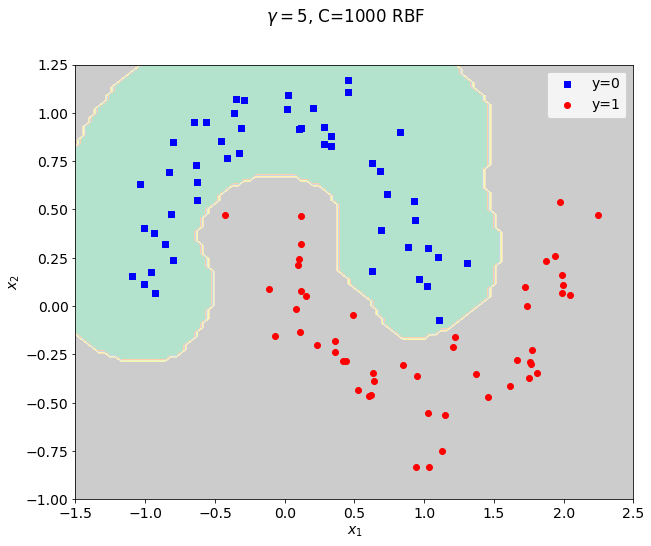

In [178]:
draw_moon_classification(rbf_kernel_svm_clf_large_g_large_c, '$\gamma=5$, C=1000 RBF')

- Increasing $\gamma$ makes the decision boundary stick more closely to the data points - could end up overfitting; small $\gamma$ makes a slower-changing boundary - could end up underfitting

- Increasing $C$ _decreases_ regularisation, making the boundary more irrelgular

## Computational Complexity

`LinearSVC` based on `liblinear` library - optimised algo, but doesn't do kernel trick. Scales linearly $\sim m, \sim n$.

`SVC` class based on `libsvm` library - can do kernel trick. Scales as $\mathcal{O}(m^2 \times n)$ to $\mathcal{O}(m^3 \times n)$ - slow when # samples is large (e.g. few 100K). Scales well with # features, esp. when sparse.

For comparison, `SGDClassifier` scales as $\mathcal{O}(m \times n)$. Doesn't do kernel trick, but unlike others can do out-of-core support.

# SVM Regression

To use SVM for regression, **reverse the objective** - try to fit **as many instances as possible on the street** (while limiting margin violations).

Street width controlled by hyperparameter $\epsilon$. If adding more training instances does not affect the model predictions, then it is **$\epsilon$-insensitive**.

In [5]:
from sklearn.svm import LinearSVR

In [187]:
?np.random.rand

In [207]:
# generate some dummy data:
m = 50
X = 2 * np.random.rand(m, 1) - 1  # generate between -1 and 1
y = 4 + 3*X + np.random.rand(m, 1) - 0.5

In [208]:
linear_svr = LinearSVR(epsilon=1.5)
linear_svr.fit(X, y.ravel())  # for some reason it wants a row vector for y instead of column

LinearSVR(epsilon=1.5)

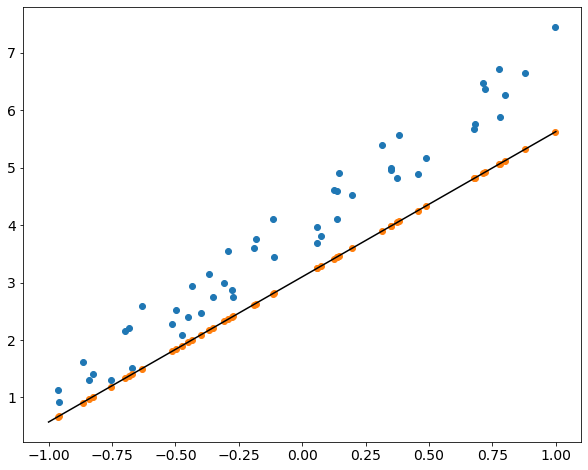

In [209]:
plt.scatter(X, y)
x = np.linspace(-1, 1, 100).reshape(-1, 1)
y_svr = linear_svr.predict(x)
y_svr2 = linear_svr.predict(X)
plt.plot(x, y_svr, 'k-')
plt.scatter(X, y_svr2)

Can also do kernel version using `SVR` class:

In [6]:
from sklearn.svm import SVR

In [199]:
svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y.ravel())

SVR(C=100, degree=2, kernel='poly')

In [200]:
svm_poly_reg.coef_

AttributeError: coef_ is only available when using a linear kernel

# The Maths of SVMs

Bias term = $b$
Feature weights = $\vec{w}$

No bias feature added to input feature vectors.

Linear SVM: Predict class of new instance $\vec{x}$ by computing decision function $h = \vec{w} \cdot \vec{x} + b = w_1 x_1 + \cdots + w_n x_n + b$. If $>0$, predicted class $\hat{y} = 1$, else 0.

\begin{equation}
\hat{y} = 
\begin{cases}
    0 \text{ if } \vec{w} \cdot \vec{x} + b <0 \\
    1 \text{ if } \vec{w} \cdot \vec{x} + b \geq 0
\end{cases}
\end{equation}

For $n=2$, can think of decision function as plane in 3D with z axis $h = \vec{w} \cdot \vec{x} + b$, and decision boundary is where it intersects the horizontal plane $h=0$.

Generally, if $n$ features, then $h$ is a $n$-dim hyperplane, and decision boundary a $(n-1)$-dim hyperplane.

The "street" margins are where the plane intersects $h = \pm 1$.

Note that the shallower the intersection of the plane, the wider the street.

The gradient of the plane is controlled by $\vec{w}$, e.g. in one dimension, the street edges are determined by $w x = \pm1 \to x = \pm 1/w$. So the width of the street is inversely proportional to $w$, more specifically $\|\vec{w}\|$.

So to find the widest street (i.e. best separation between classes), we want to minimize $\|\vec{w}\|$. (Actually, easier to minimise $\| \vec{w} \|^2$, while $\| \vec{w} \|$ isn't differentiable at $\vec{w} = 0$.)

**Hard margin**: We can also specify that, for a hard margin, we require $h > 1$ for all $y =1$, and $h < -1$ for all $y=0$ instances (i.e. **all outside the street**). Defining $t^{(i)} = -1$ for $y^{(i)}=0$ and $t^{(i)} = 1$ for $y^{(i)}=1$, we can express this as $t^{(i)} h^{(i)} = t^{(i)} (\vec{w}\cdot\vec{x}^{(i)} + b) \geq 1~\forall~i$.

\begin{equation}
\text{Minimise: } \| \vec{w} \|^2 \text{ wrt } \vec{w}, b\\
\text{Subject to: } t^{(i)} h^{(i)} = t^{(i)} (\vec{w}\cdot\vec{x}^{(i)} + b) \geq 1~\forall~i
\end{equation}

This is our **primal problem**.

**Soft margin**: introduce **slack variable** $\zeta^{(i)} \geq 0$ for each instance (turns inequality into equality): measures how much that instance is allowed to violate the margin - narrower street means less violations. This is in conflict with minimising $\| \vec{w} \|^2$. $C$ hyperparameter governs trade-off between 2 objectives: we now have the objective 
\begin{equation}
\text{Minimise: } \| \vec{w} \|^2 + C \sum_{i1}^m \zeta^{(i)}  \text{ wrt } \vec{w}, b, \zeta\\
\text{Subject to: } t^{(i)} h^{(i)} = t^{(i)} (\vec{w}\cdot\vec{x}^{(i)} + b) \geq 1 - \zeta^{(i)} ~\forall~i \text{ with } \zeta^{(i)} \geq 0
\end{equation}

Both of these are **convex quadratic optimisation problems** - **quadratic programming** (QP) problems.

QP problems have the general form:
\begin{equation}
\text{Minimise: } \vec{p}^T \mathbf{H} \vec{p} + \vec{f}^T \vec{p}  \text{ wrt } \vec{p}\\
\text{Subject to: } \mathbf{A}\vec{p} \leq \vec{p}
\end{equation}

So be able to use the kernel trick, instead of the above **primal problem**, we use the **dual problem** - related but different. Since SVM problem is convex, and its inequality constraints are convex and continuously differentiable, in this case the dual solution is **exactly** the primal solution (NB not in general, generally only lower bound!)

The dual problem is **faster to solve** if $m < n$, and allows for the kernel trick.

The SVM objective in dual form is:

\begin{equation}
\text{minimise } \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \vec{x}^{(i)} \vec{x}^{(j)} = \sum_{i=1}^m \alpha^{(i)}  \text{ wrt } \vec{\alpha} \\
\text{subject to } \alpha^{(i)} \geq 0~\forall~i=1, \ldots, m \text{ and } \sum_{i=1}^m \alpha^{(i)} t^{(i)} = 0
\end{equation}

Solving this gives $\hat{\vec{\alpha}}$, which can then be converted back to $\vec{w}, b$:

\begin{equation}
\hat{\vec{w}} = \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \vec{x}^{(i)} \\
\hat{b} = \frac{1}{n_s} \sum_{i=1}^m \left( t^{(i)} - \hat{\vec{w}}^T\vec{x}^{(i)} \right) \text{ when } \hat{\alpha}^{(i)} > 0
\end{equation}

where $n_s$ is # of support vectors.

## Kernel trick

If we wanted to apply a 2nd order polynomial mapping, we would have:

\begin{equation}
\phi(\vec{x}) = \phi \left(\pmatrix{x_1 \\ x_2} \right) = \pmatrix{x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2}
\end{equation}

which maps from $\mathbb{R}_{2} \to \mathbb{R}_{3}$ vector.

We can apply the same transformation to vectors $\vec{a}, \vec{b}$, and take their dot product.

\begin{equation}
\phi(\vec{a}) \cdot \phi(\vec{b}) = \pmatrix{a_1^2 \\ \sqrt{2} a_1 a_2 \\ a_2^2}^T \pmatrix{b_1^2 \\ \sqrt{2} b_1 b_2 \\ b_2^2} = a_1^2 b_1^2 + 2a_1b_1a_2b_2 + a_2^2b_2^2 = (a_1b_1 + a_2b_2)^2 = (\vec{a} \cdot  \vec{b})^2
\end{equation}

So the dot product of the transformed vectors is equal to the square of the dot product of the original vectors.

Crucially, if $\phi$ is applied to the training data, then the dual problem already contains the term $\phi(\vec{x}^{(i)}) \cdot \phi(\vec{x}^{(j)})$. Which means we can use the above trick, replacing all dot products by their square - so we don't have to manually pre-calculate all the squares on the training data.

More generally, we define a **kernel** $K(\vec{a}, \vec{b})$ as a function capable of computing the dot product $\phi(\vec{a}) \cdot \phi(\vec{b})$ only using the original vectors $\vec{a}, \vec{b}$, **without** computing the transformations $\phi(\vec{x}), \phi(\vec{b})$ explicitly.

Some kernels:

- Linear: $K = \vec{a}\cdot\vec{b}$
- Polynomial: $K = (\gamma\vec{a}\cdot\vec{b} + r)^d$
- Gaussian RBF: $K = -\exp(-\gamma \| \vec{a} - \vec{b} \| ^2)$
- Sigmoid: $K = \tanh(\gamma\vec{a}\cdot\vec{b} + r)$


An additional twist in the kernel trick: the dual problem will still contain terms $\phi(\vec{x}^{(i)})$, which may be huge and uncomputable. So how can we determine $\hat{\vec{w}}$ and make predictions?

To make predictions, we can plug the formula for $\hat{\vec{w}}$ into the decision function, and we only end up with dot products between input vectors, which solves that uncomputable issue:


\begin{equation}
h(\phi(\vec{x}^{(n)})) = \hat{\vec{w}}^T \phi(\vec{x}^{(n)}) + \hat{b} \\
= \left( \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \phi(\vec{x}^{(i)}) \right)^T \phi(\vec{x}^{(n)}) + \hat{b} \\
= \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \left( \phi(\vec{x}^{(i)})^T \phi(\vec{x}^{(n)}) \right) + \hat{b} \\
= \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K\left(\vec{x}^{(i)}, \vec{x}^{(n)} \right) + \hat{b} \text{ for } \alpha^{(i)} > 0
\end{equation}

Now, $\alpha^{(i)} \neq 0 $ only for support vectors, so we only need dot product of new instances $\vec{x}^{(n)}$ with the support vector, not the whole training set.

A similar trick can be used to calculate the bias term.

# Online SVMs

Online learning = learning incrementally, as new data arrives.

For linear SVMs: can use SGD with modified cost function (but converges much more slowly than QP):

\begin{equation}
J(\vec{w}, b) = \frac{1}{2} \vec{w}\cdot\vec{w} + C\sum_{i=1}^m \max(0, 1-t^{(i)}(\vec{w}\cdot\vec{x}^{(i)} + b))
\end{equation}

where the function $\max(0, 1-t)$ is the **hinge loss function**. 

The first term in $J$ will try and reduce $\vec{w}$, causing a larger margin.

The second term accounts for margin violations - 0 if on correct side, but linearly proportional to the distance if on wrong side.

# Multiclass classification

Let's try a simple 3-class problem. By default, SVC uses a OvO system, therefore needing 3 * (3-1) / 2 = 3 classifiers.

However, `LinearSVC` uses a OvR system by default, therefore needing 3 classifiers.

We'll also ensure that our classes aren't easily linearly separable - let there be some inevitable margin violations to compare the classifiers:

In [7]:
from sklearn.datasets import make_classification

In [331]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, 
                           n_classes=3, class_sep=2, n_clusters_per_class=1)

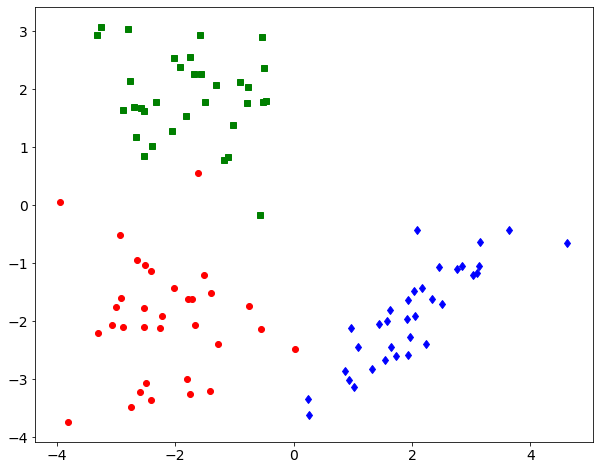

In [332]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
plt.plot(X[y==2][:,0], X[y==2][:,1], 'ro')

In [333]:
def draw_decision_regions(clf, x1_min, x1_max, x2_min, x2_max):
    x1 = np.linspace(x1_min, x1_max, 100)
    x2 = np.linspace(x2_min, x2_max, 100)
    X1, X2 = np.meshgrid(x1, x2) # for 2D feature space
    y_pred = clf.predict(np.c_[X1.reshape(-1, 1), X2.reshape(-1, 1)])
    plt.contourf(X1, X2, y_pred.reshape(X1.shape), cmap='Pastel2')

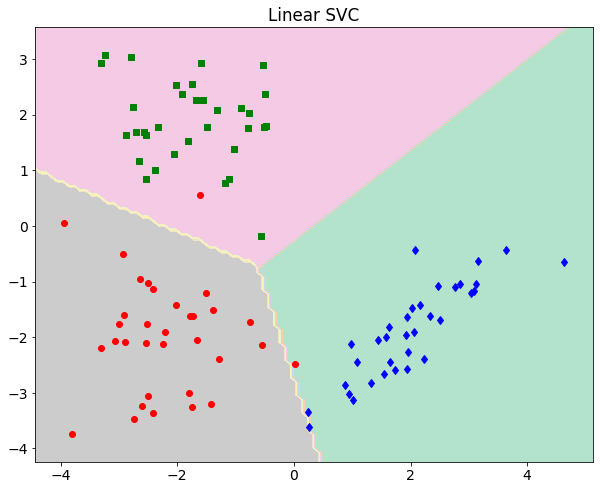

In [334]:
svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(C=1, loss='hinge'))
])
linear_svc_clf.fit(X, y)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
plt.plot(X[y==2][:,0], X[y==2][:,1], 'ro')
x1_min = X[:, 0].min() - 0.5
x1_max = X[:, 0].max() + 0.5
x2_min = X[:, 1].min() - 0.5
x2_max = X[:, 1].max() + 0.5
draw_decision_regions(linear_svc_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("Linear SVC");

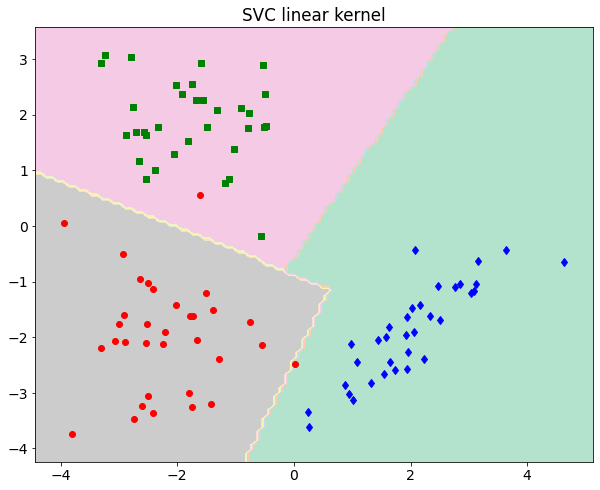

In [335]:
svc_lin_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear', C=1))
])
svc_lin_clf.fit(X, y)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
plt.plot(X[y==2][:,0], X[y==2][:,1], 'ro')
x1_min = X[:, 0].min() - 0.5
x1_max = X[:, 0].max() + 0.5
x2_min = X[:, 1].min() - 0.5
x2_max = X[:, 1].max() + 0.5
draw_decision_regions(svc_lin_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("SVC linear kernel");

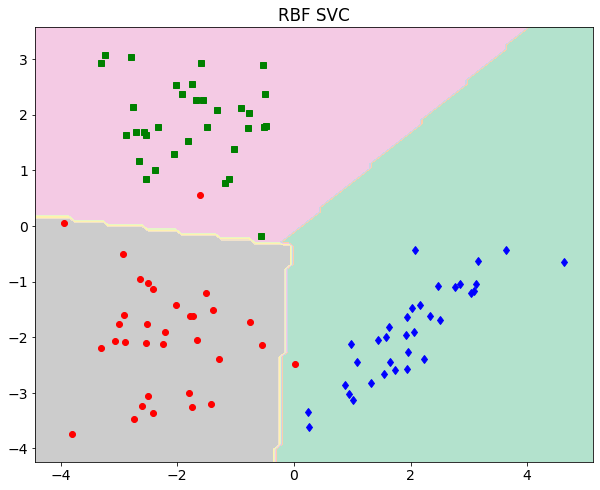

In [341]:
gaus_svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=1, gamma=0.01))
])
gaus_svc_clf.fit(X, y)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
plt.plot(X[y==2][:,0], X[y==2][:,1], 'ro')
draw_decision_regions(gaus_svc_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("RBF SVC");

We can now see some very different decision boundaries between all 3: especially in the region (0, -1).

# Exercises

## 1. Fundamental idea behind SVMs?

Fit the widest possible "street" between classes, i.e. the largest margin around a decision boundary, whilst minimising the magnitude & number of "violations"

## 2. What is a support vector?

The set of data points (subset of full dataset) that fully determine the boundary & its margins.

## 3. Why scale inputs?

Since SVM tries to find the largest margin, smaller unscaled inputs will be ignored in favour of the larger scale inputs.

## 4. Can an SVM output a confidence score? A probability?

You can get a distance between a point and the margin, as a pseudo confidence score.

SVC doesn't give a probability. To get a probability, you can also fit a SVR, to then get a probability.

## 5. Primal or dual form of the SVM problem to train a model w/1M instances, 100s of features?

(Only for linear - kernel can only use dual form)

Primal form: $\mathcal{O}(m)$

Dual form: $\mathcal{O}(m^2) - (m^3)$

so for 1M instances, use primal form.

## 6. Underfitting with RBF kernel, how to modify gamma? C?

Increase $\gamma$ to improve model. Can also increase C.

## 7. How to set QP params to solve soft margin linear SVM using generic QP solver?

## 8. Train LinearSVC on linearly separable dataset, repeat with SVC & SGDClassifier - try to get same result.

In [8]:
from sklearn.datasets import make_classification

In [309]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_repeated=0, 
                           class_sep=3, n_clusters_per_class=1)

In [310]:
X.shape

(100, 2)

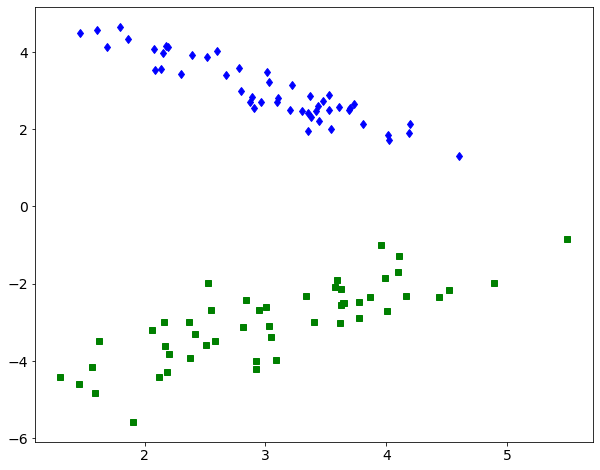

In [311]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')

[-0.03479501] [[ 0.16588482 -1.983252  ]]


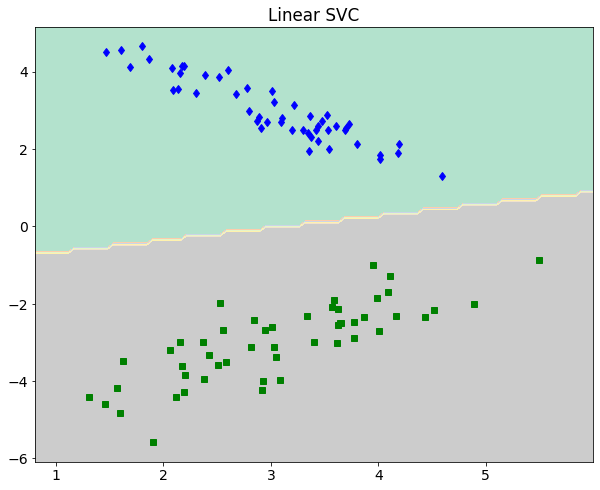

In [317]:
linear_svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(C=1, loss='hinge'))
])
linear_svc_clf.fit(X, y)
print(linear_svc_clf.named_steps['clf'].intercept_, linear_svc_clf.named_steps['clf'].coef_)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
x1_min = X[:, 0].min() - 0.5
x1_max = X[:, 0].max() + 0.5
x2_min = X[:, 1].min() - 0.5
x2_max = X[:, 1].max() + 0.5
draw_decision_regions(linear_svc_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("Linear SVC");

[-0.03459801] [[ 0.16577978 -1.98350012]]


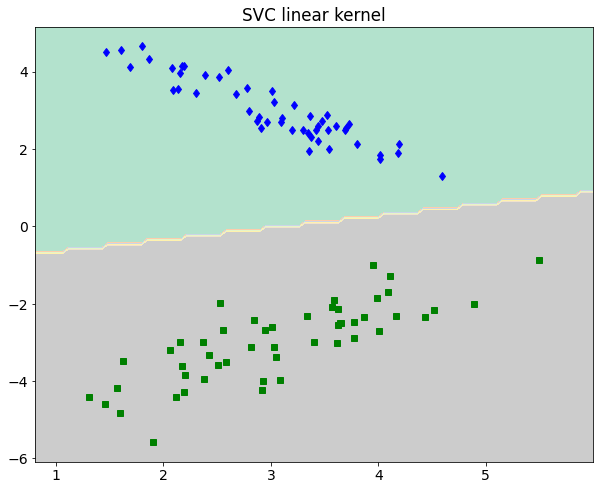

In [318]:
svc_lin_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='linear', C=1))
])
svc_lin_clf.fit(X, y)
print(svc_lin_clf.named_steps['clf'].intercept_, svc_lin_clf.named_steps['clf'].coef_)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
draw_decision_regions(svc_lin_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("SVC linear kernel");

So LinearSVC and SVC with linear kernel give v.v.close results.

In [9]:
from sklearn.linear_model import SGDClassifier

[0.05197653] [[ 0.32316681 -2.17232161]]


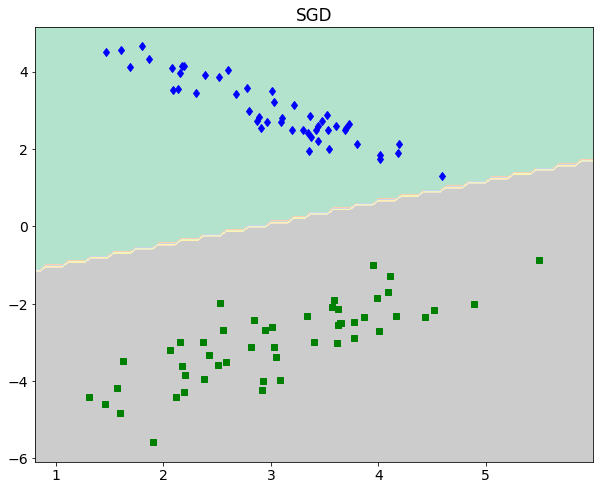

In [320]:
sgd_lin_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SGDClassifier(loss='hinge', alpha=1./(1.*len(y)), penalty='l2'))  # alpha = 1/(C*m)
])
sgd_lin_clf.fit(X, y)
print(sgd_lin_clf.named_steps['clf'].intercept_, sgd_lin_clf.named_steps['clf'].coef_)
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
draw_decision_regions(sgd_lin_clf, x1_min, x1_max, x2_min, x2_max)
plt.title("SGD");

`SGDClassifier` isn't quite close as the others

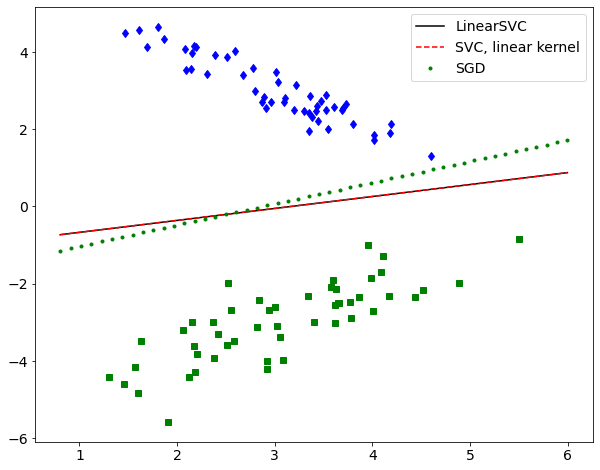

In [322]:
plt.plot(X[y==0][:,0], X[y==0][:,1], 'bd')
plt.plot(X[y==1][:,0], X[y==1][:,1], 'gs')
draw_decision_boundary(linear_svc_clf, x1_min, x1_max, 'k-', label='LinearSVC')
draw_decision_boundary(svc_lin_clf, x1_min, x1_max,  'r--', label='SVC, linear kernel')
draw_decision_boundary(sgd_lin_clf, x1_min, x1_max, 'g.', label='SGD')
# plt.title("Linear SVC");
plt.legend();

## 9. Train SVM on MNIST, use OvR

Train SVM on MNIST. Use OvR. Use small validations sets to tune hyperparameters.

See also the guide from libsvm: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf

In [10]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [12]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [13]:
# Use LinearSVC as it defaults to OvR
# This will take a while
# Note that verbosity messages will be printed to **terminal** not here
lin_clf = LinearSVC(C=1, loss='hinge', random_state=42, verbose=1)
lin_clf.fit(X_train, y_train)

[LibLinear]

/Users/robin/.virtualenvs/handsonml/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, loss='hinge', random_state=42, verbose=1)

In [11]:
from sklearn.metrics import accuracy_score

In [15]:
y_train_predict = lin_clf.predict(X_train)
accuracy_score(y_train_predict, y_train)

0.8931166666666667

So 89% accuracy (on training set), which can definitely be improved upon (our K-nearest neighbors classifier achieved 97% accuracy on its training & test scores)

Do we need to use StandardScaler, even though all pixels are normalised to [0, 255]?

In [17]:
linear_svc_mnist_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(C=1, loss='hinge', random_state=42))
])
linear_svc_mnist_clf.fit(X_train, y_train)

/Users/robin/.virtualenvs/handsonml/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, loss='hinge', random_state=42))])

In [20]:
y_train_predict = linear_svc_mnist_clf.predict(X_train)
accuracy_score(y_train_predict, y_train)

0.9278833333333333

So scaling **does** make a difference - here raising accuracy from 89% to 93%. But the Linear kernel is probably holding us back. So we should try a different kernel, e.g. RBF.

In [13]:
rbf_svc_mnist_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=1, gamma='scale', random_state=42))
])
rbf_svc_mnist_clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=1, random_state=42))])

In [14]:
y_train_predict = rbf_svc_mnist_clf.predict(X_train)
accuracy_score(y_train_predict, y_train)

0.9866333333333334

Takes forever (why?), but Yay much better! Even without optimising C, gamma. Even better than K nearest neighbors

In [15]:
y_test_predict = rbf_svc_mnist_clf.predict(X_test)
accuracy_score(y_test_predict, y_test)

0.966

So close to 97% accuracy on the test set.

We could do a grid or random search as well to find a better C, gamma. But this would take forever...

## 10. Train SVR on California housing dataset

In [21]:
from sklearn.datasets import fetch_california_housing

In [22]:
housing = fetch_california_housing()
X_housing = housing["data"]
y_housing = housing["target"]

In [23]:
from sklearn.model_selection import train_test_split

Note that this isn't the best way to split it - in Chapter 2 we saw that really we need to maintain the same split by income categories to do it fairly.

In [24]:
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_housing, y_housing, test_size=0.2, random_state=42)

In [25]:
X_housing_train.shape

(16512, 8)

In [26]:
y_housing_train.shape

(16512,)

We'll try a simple linear SVR first to get a baseline performance. We definitely need to scale our features first.

In [31]:
lin_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', LinearSVR(C=1, dual=True, verbose=1, max_iter=3000, random_state=42)),
])
lin_svr.fit(X_housing_train, y_housing_train)

[LibLinear]

Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=1, max_iter=3000, random_state=42, verbose=1))])

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [44]:
y_housing_train_predict = lin_svr.predict(X_housing_train)
print("RMSE:", np.sqrt(mean_squared_error(y_housing_train_predict, y_housing_train)))
print("MAE:", mean_absolute_error(y_housing_train_predict, y_housing_train))

RMSE: 0.979565447829459
MAE: 0.5111192378159244


Note that this is the median house value in 100K\\$. So we have a RMSE of 98,000\\$, which is large.

In [35]:
lin_svr.named_steps['scaler'].scale_

array([1.90423626e+00, 1.26021177e+01, 2.38730258e+00, 4.33201426e-01,
       1.13702195e+03, 1.15783935e+01, 2.13660060e+00, 2.00559281e+00])

Let's instead try a RBF kernel:

In [46]:
rbf_svr = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', gamma='scale', C=1, verbose=1)),
])
rbf_svr.fit(X_housing_train, y_housing_train)

[LibSVM]

Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR(C=1, verbose=1))])

In [47]:
y_housing_train_predict = rbf_svr.predict(X_housing_train)
print("RMSE:", np.sqrt(mean_squared_error(y_housing_train_predict, y_housing_train)))
print("MAE:", mean_absolute_error(y_housing_train_predict, y_housing_train))

RMSE: 0.5797673265358964
MAE: 0.38311919249736526


So already better, even without optimising C, gamma. Let's try it on the test set:

In [48]:
y_housing_test_predict = rbf_svr.predict(X_housing_test)
print("RMSE:", np.sqrt(mean_squared_error(y_housing_test_predict, y_housing_test)))
print("MAE:", mean_absolute_error(y_housing_test_predict, y_housing_test))

RMSE: 0.5974969813107396
MAE: 0.39859828301457556


So decent performance on the test set as well. Our random forest model had a RMSE of about 53K.